In [1]:
import sys
sys.path.append('../')
import numpy as np
from fragmodel.fragmentation_model import FragmentationModel
from fragmodel.planet import Planet
from fragmodel.solver import MCMCSolver, denormalize
import matplotlib.pyplot as plt
import os 
import emcee
import logging

logger = logging.getLogger('fragmodel')
logger.setLevel(logging.ERROR)

In [2]:
def get_model(v, theta, Ch, sigma, rho_d, M_frac, P_release_frag, sigma_frag):
    planet = Planet("Earth")
    # planet.define_planet(EARTH)
    planet.define_temperature_profile('earthtp/chelyabinsk_50k.tp')

    ''' initial parameters for the main body '''
    M      = 1.185e7
    h0     = 45000.
    alpha  = 0.18
    Cfr    = 1.5

    ''' initialize the model '''
    fragmodel = FragmentationModel(M, v, theta, h0, sigma, Ch, rho_d, Cfr, alpha, planet)
    fragmodel.add_fragment(M * M_frac, P_release_frag, fragment_strength=sigma_frag)

    return fragmodel

In [3]:
parameters = {
    'v': {'min': 12000., 'max': 22000.},
    'theta': {'min': 0., 'max': 45.},
    'Ch': {'min': 1e-9, 'max': 1e-8},
    'sigma': {'min': 0.1e6, 'max': 1e6},
    'rho_d': {'min': 1000., 'max': 5000.},
    'M_frac': {'min': 0.01, 'max': 0.05},
    'P_release_frag': {'min': 0.5e6, 'max': 4e6},
    'sigma_frag': {'min': 5e6, 'max': 15e6},
}

In [4]:
solver = MCMCSolver()
solver.set_parameters(parameters)

# get the observed energy deposition profile
energydepdata = np.loadtxt('energydep/ChelyabinskEnergyDep_Wheeler-et-al-2018.txt', skiprows=1)

solver.set_lightcurve(energydepdata[:, 0] * 1e3, energydepdata[:, 1], 0.01, 'energy_deposition')
solver.set_integration_parameters({'dt': 1e-2, 'max_time': 25.})

In [5]:
sampler = solver.run_mcmc(get_model, num_steps=150, n_walkers=32, threads=10)

/mnt/d/CodeProjects/fragmentationmodel/tests/../fragmodel/fragment.py:150: RuntimeWarning: invalid value encountered in sqrt
  self.state.radius = np.sqrt(S / (np.pi))
 11%|█████████▎                                                                        | 17/150 [00:27<03:43,  1.68s/it]/mnt/d/CodeProjects/fragmentationmodel/tests/../fragmodel/fragment.py:150: RuntimeWarning: invalid value encountered in sqrt
  self.state.radius = np.sqrt(S / (np.pi))
100%|█████████████████████████████████████████████████████████████████████████████████| 150/150 [06:00<00:00,  2.40s/it]


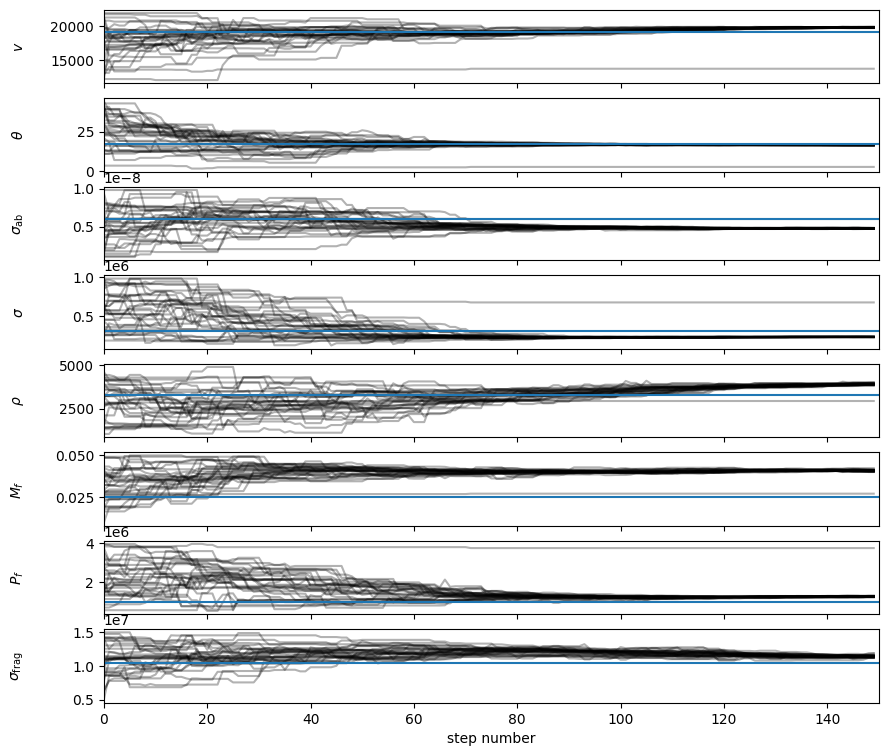

In [11]:
fig, axes = plt.subplots(solver.ndims, figsize=(10, 9), sharex=True)
samples = solver.sampler.get_chain()

labels = [r'$v$', r'$\theta$', r'$\sigma_{\rm ab}$', r'$\sigma$', r'$\rho$', r'$M_f$', r'$P_f$', r'$\sigma_{\rm frag}$']
truths=[19040, 17, 0.12 / 2e7, 0.3e6, 3300, 0.025, 0.975e6, 10.5e6]

for i in range(solver.ndims):
    ax = axes[i]
    param = solver.parameters[solver.parameter_names[i]]
    ax.plot(denormalize(samples[:, :, i], param['min'], param['max']), "k", alpha=0.3)
    ax.axhline(truths[i])
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

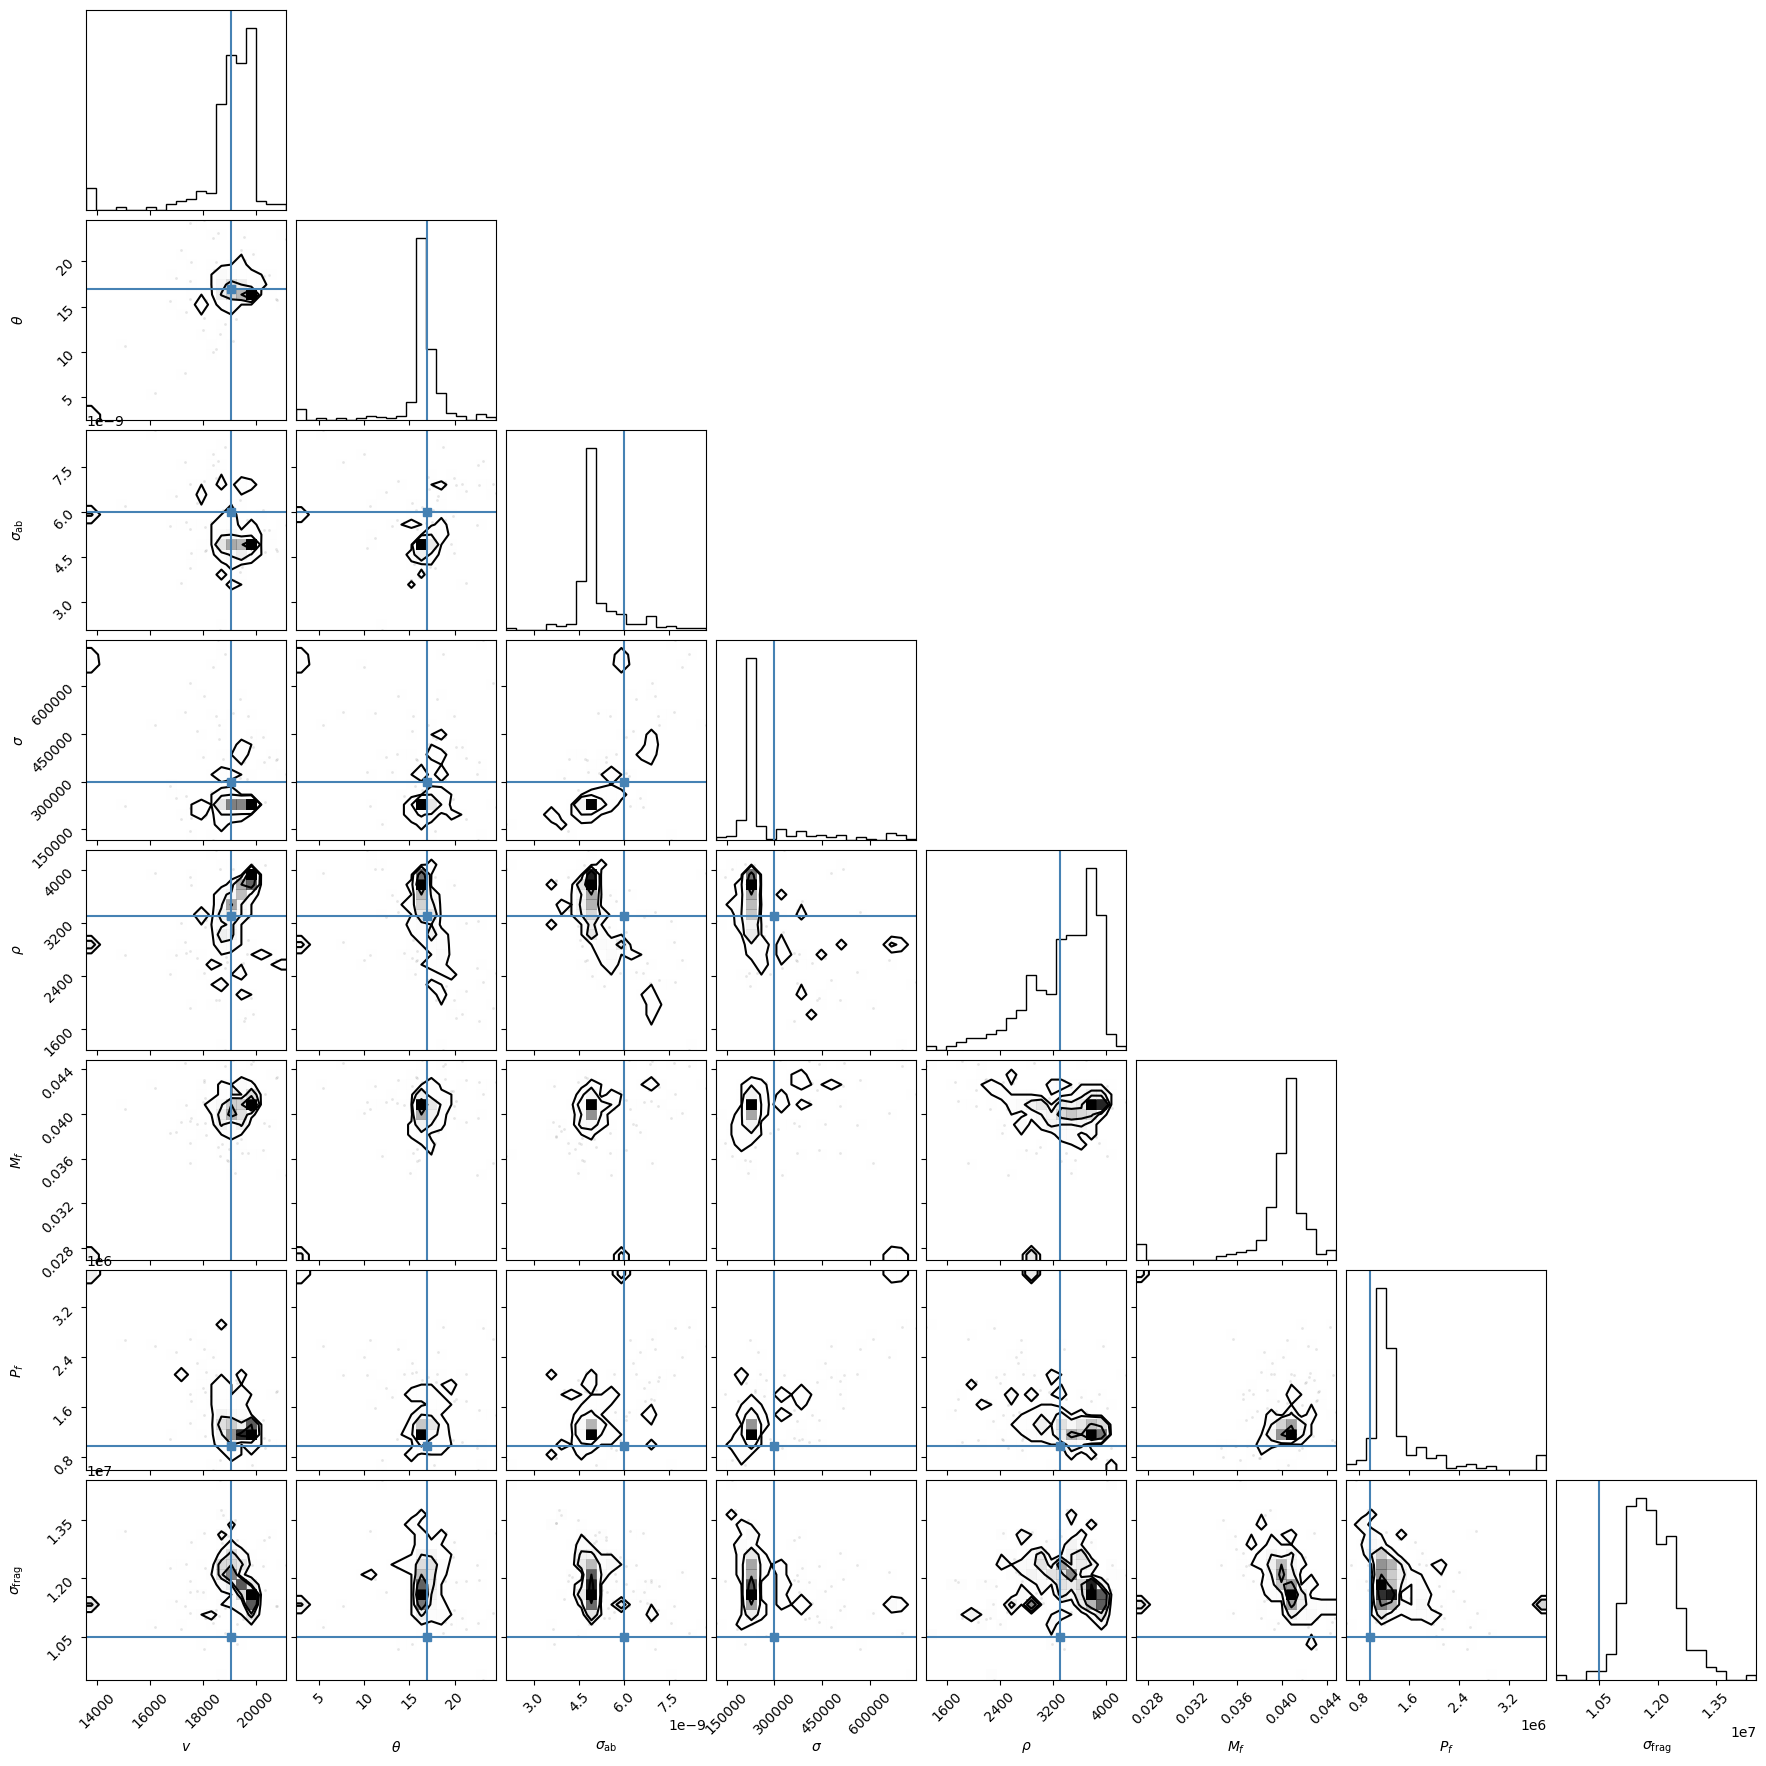

In [13]:
import corner
flat_samples = solver.sampler.get_chain(discard=20, thin=15, flat=True)
# de-normalize the values
for i in range(solver.ndims):
    param = solver.parameters[solver.parameter_names[i]]
    flat_samples[:, i] = denormalize(flat_samples[:, i], param['min'], param['max'])

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);

In [14]:
mcmc = np.percentile(flat_samples, 50, axis=0)

input_dict = {key: value for key, value in zip(solver.parameter_names, mcmc)}
print(input_dict)

frag_model_best = get_model(**input_dict)
df = frag_model_best.integrate(**solver.integration_parameters)

{'v': 19254.296809131713, 'theta': 16.671456523613507, 'Ch': 4.863281746572127e-09, 'sigma': 224652.81090841285, 'rho_d': 3481.896039958694, 'M_frac': 0.0404688324980031, 'P_release_frag': 1255842.5544966706, 'sigma_frag': 11818634.160647353}


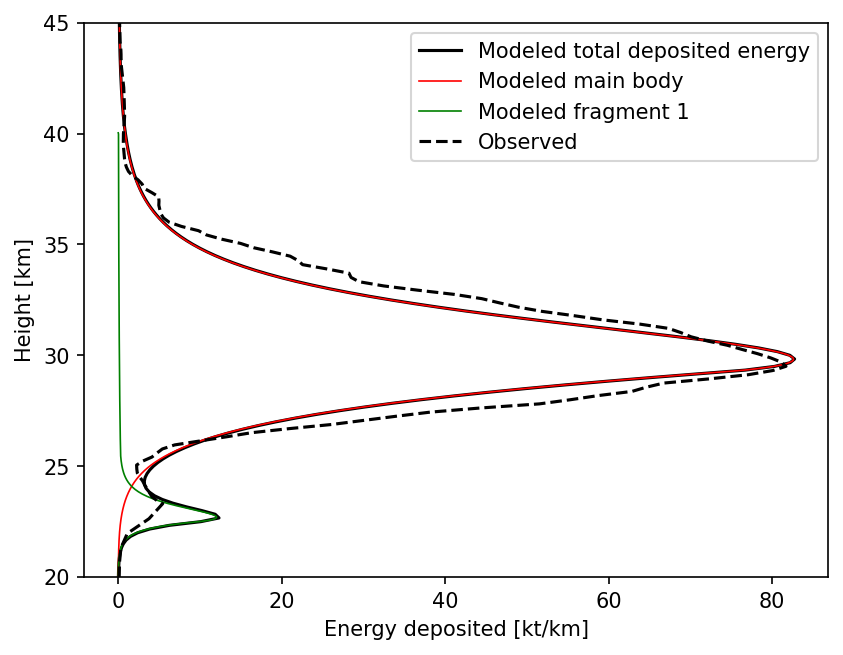

In [15]:
fig, ax = plt.subplots(1, 1, dpi=150)

# 1 kt in joules
kt = 4.184e12

# we need to interpolate the energy deposition curves from the different fragments
# onto the same height grid because they are traveling at different velocities
height = np.linspace(20, 45, 151) * 1e3
# flip the order since np.interp expects sorted x values
f1_deposited = np.interp(height, df['f1.height'][::-1], df['f1.deposited'][::-1]  * (1000 / kt))
main_deposited = np.interp(height, df['main.height'][::-1], df['main.deposited'][::-1]  * (1000 / kt))
ax.plot((main_deposited + f1_deposited), height / 1e3, 'k-', label='Modeled total deposited energy')

# plot the individual energy deposition curves
ax.plot(df['main.deposited'] * (1000 / kt), df['main.height']/1000., 'r-', label='Modeled main body', linewidth=0.8)
ax.plot(df['f1.deposited'] * (1000 / kt), df['f1.height']/1000., 'g-', label='Modeled fragment 1', linewidth=0.8)

# plot the observed data
ax.plot(energydepdata[:,1], energydepdata[:,0], 'k--', label='Observed')
ax.set_ylim((20., 45.))
ax.set_xlabel(r'Energy deposited [kt/km]')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

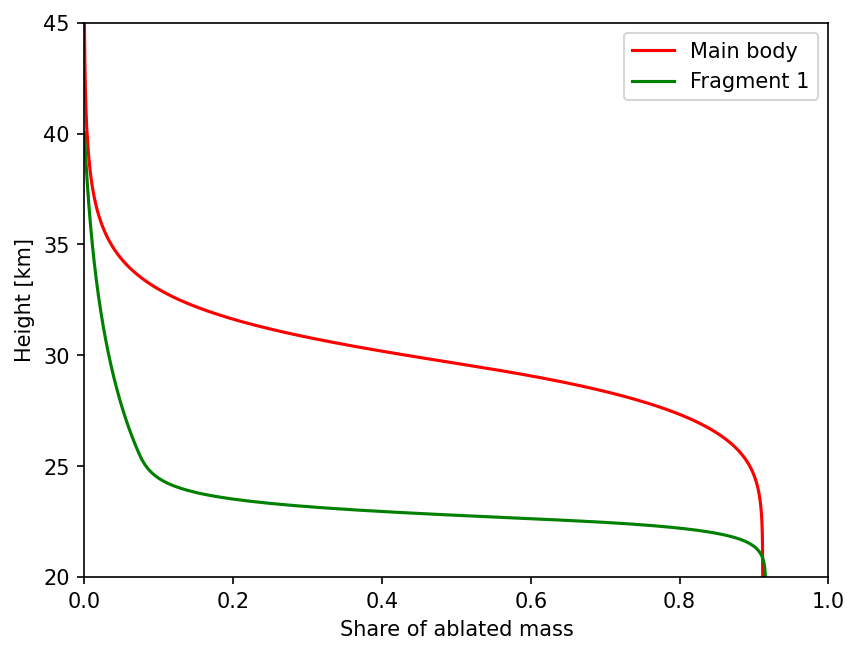

In [16]:
''' second plot is the fraction of mass that is ablated '''
fig, ax = plt.subplots(1, 1, dpi=150)

## construct the ablated mass profile
mfrag1 = np.array(df['f1.mass'])
mfrag1[np.isfinite(mfrag1)] = frag_model_best.fragments[0].initial_mass
mfrag1[np.isnan(mfrag1)] = 0
mmain = frag_model_best.main_body.initial_mass - mfrag1
mainablation = 1. - df['main.mass'] / mmain

ax.plot(mainablation, df['main.height'] / 1e3, 'r-', label='Main body')
ax.plot(1 - df['f1.mass'] / frag_model_best.fragments[0].initial_mass, df['f1.height'] / 1e3, 'g-', label='Fragment 1')

ax.set_ylim((20., 45.))
ax.set_xlim((0., 1.))
ax.set_xlabel(r'Share of ablated mass')
ax.set_ylabel(r'Height [km]')
ax.legend(loc='upper right')

plt.show()